In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/My Drive/colab notebooks/proposals-analyze"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/colab notebooks/proposals-analyze


In [2]:
%pip install tensorflow_text
%pip install "tf-models-official==2.15.*"

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import json
import tqdm

import utils_v3 as utils

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

from official.nlp import optimization  # to create AdamW optimizer

from networks import CustomSchedule, Transformer

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
keras.utils.set_random_seed(SEED)

#### Load and prepare data

In [4]:
dataset_name = 'ml'

projects = utils.load_projects(dataset_name)
users = utils.load_users(dataset_name)

data = utils.load_bids_df(projects,users)
data['bid_text'] = data['bid_text'].fillna('')

In [5]:
X_1, X_2 = data['title'] + '\n' + data['description'].values, data['bid_text'].values
y = data['awarded'].values

pos_weight = len(y) / sum(y)
sample_weight = y * pos_weight + 1.

In [6]:
df_prepared = utils.prepare_df(data)
df_prepared = df_prepared.drop(['proj_id', 'awarded'], axis=1)

cols_num = df_prepared.select_dtypes(include=['number']).columns
cols_cat = df_prepared.select_dtypes(exclude=['number']).columns

scaler = StandardScaler()
X_num = scaler.fit_transform(df_prepared[cols_num])

X_3 = np.append(X_num, df_prepared[cols_cat], axis=1).astype('float32')

### Training models

In [ ]:
class BidsClassifier(keras.Model):
    def __init__(self, texts_model, features_num, dropout_rate=.1):
        super().__init__()

        self.texts_model = texts_model
        self.features_head = keras.models.Sequential([
            keras.layers.Dense(features_num, activation='relu',
                               input_shape=(features_num,)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(dropout_rate),
            keras.layers.Dense(features_num, activation='relu')
        ])

        self.concat = keras.layers.Concatenate()
        self.dropout = keras.layers.Dropout(dropout_rate)

        self.final_layer = keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        *texts, feat = x

        feat = self.features_head(feat)
        x = self.texts_model(texts)

        x = self.concat([x,feat])
        x = self.dropout(x)

        x = self.final_layer(x)

        return x

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(((X_2,X_1,X_3), y, sample_weight))

#### Training pretrained BERT model

In [ ]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 64

def make_ds(ds):
    return (ds
            .shuffle(BUFFER_SIZE, seed=SEED)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

ds_size = len(X_1)

train_size,val_size = int(ds_size*.7),int(ds_size*.1)

train_ds = make_ds( ds.take(train_size) )
val_ds = make_ds( ds.skip(train_size).take(val_size) )
test_ds = make_ds( ds.skip(train_size+val_size) )

In [ ]:
for batch,labels,weights in train_ds.take(1):
    print(batch[0][:1])

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [13]:
import tensorflow_hub as hub

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = batch[0][:1]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  7632  1010  2026  2171  2003 24547  2063  1010  1045  2572  1037]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [16]:
classifier_model = build_classifier_model()

class BertClassifier(keras.Model):
    def __init__(self):
        super().__init__()

        self.proj_clf = build_classifier_model()
        self.bid_clf = build_classifier_model()

        self.concat = keras.layers.Concatenate()

    def call(self,x):
        proj,bid = x

        x = [self.proj_clf(proj), self.bid_clf(bid)]
        x = self.concat(x)

        return x

bert_model = BertClassifier()
model = BidsClassifier(bert_model, X_3.shape[1])

In [17]:
epochs = 7
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [18]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Recall(),
                          keras.metrics.Precision()],
                  weighted_metrics=[])

In [19]:
model.fit(train_ds,epochs=epochs,validation_data=val_ds)
model.evaluate(test_ds)

Epoch 1/7
157/157 [==============================] - 183s 1s/step - loss: 1.4846 - accuracy: 0.5833 - recall: 0.4088 - precision: 0.0619 - val_loss: 1.5382 - val_accuracy: 0.3578 - val_recall: 0.7373 - val_precision: 0.0894
Epoch 2/7
157/157 [==============================] - 163s 1s/step - loss: 1.3502 - accuracy: 0.6140 - recall: 0.5586 - precision: 0.0872 - val_loss: 1.7178 - val_accuracy: 0.7290 - val_recall: 0.4153 - val_precision: 0.1335
Epoch 3/7
157/157 [==============================] - 162s 1s/step - loss: 1.2238 - accuracy: 0.6740 - recall: 0.6352 - precision: 0.1138 - val_loss: 1.6982 - val_accuracy: 0.6975 - val_recall: 0.4576 - val_precision: 0.1280
Epoch 4/7
157/157 [==============================] - 172s 1s/step - loss: 1.0993 - accuracy: 0.7093 - recall: 0.6857 - precision: 0.1343 - val_loss: 1.7766 - val_accuracy: 0.7388 - val_recall: 0.4068 - val_precision: 0.1368
Epoch 5/7
157/157 [==============================] - 162s 1s/step - loss: 1.0003 - accuracy: 0.7579 - re

[2.070624828338623, 0.746065080165863, 0.4107883870601654, 0.14494875073432922]

#### Training custom Transformer

##### Tokenizer

In [20]:
texts = np.append(X_1,X_2)
text_ds = tf.data.Dataset.from_tensor_slices(texts)

In [21]:
vocab_size = 8_000
bert_tokenizer_params = {"lower_case": True}

In [22]:
vocab = bert_vocab.bert_vocab_from_dataset(
    text_ds.batch(1000).prefetch(2),
    vocab_size=vocab_size,
    reserved_tokens=['[PAD]', '[UKN]', '[START]', '[END'],
    bert_tokenizer_params=bert_tokenizer_params, learn_params={}
)

In [23]:
with open('models/vocab.txt','w') as f:
    for token in vocab:
        print(token, file=f)

In [24]:
tokenizer = text.BertTokenizer('models/vocab.txt', **bert_tokenizer_params)

In [25]:
for examples in text_ds.shuffle(buffer_size=1000).batch(3).take(1):
    for example in examples:
        print(example.numpy()[:150])

b'Build me a AI/ML model for a given time series sensor signal data \nNeed to develop a AI/ML model using various sensor signals in time series data (fea'
b'Python-Machine learning Consultant\nI am going to find senior machine learning engineer through this simple python app so that we can extend long days.'
b'Object Detection Python -- 2\nDetecting people in images and differentiating between them using the colour of their clothes.'


In [26]:
token_batch = tokenizer.tokenize(examples)
token_batch = token_batch.merge_dims(-2,-1)[:, :25]

for ex in token_batch.to_list():
    print(ex)

[406, 298, 42, 339, 18, 320, 307, 281, 42, 498, 318, 506, 1521, 893, 288, 301, 277, 496, 42, 339, 18, 320, 307, 300, 518]
[285, 16, 293, 286, 2125, 50, 292, 1059, 277, 466, 832, 293, 286, 437, 446, 294, 478, 285, 424, 312, 297, 304, 289, 4012, 773]
[487, 361, 285, 16, 16, 21, 2108, 681, 278, 445, 275, 5214, 630, 528, 300, 276, 4943, 279, 731, 2174, 17]


In [27]:
txt_tokens = tf.gather(vocab, token_batch)
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'build me a ai / ml model for a given time series sensor signal data need to develop a ai / ml model using various',
       b'python - machine learning consultant i am going to find senior machine learning engineer through this simple python app so that we can extend long',
       b'object detection python - - 2 detecting people in images and differentiating between them using the colour of their clothes .'],
      dtype=object)>

##### Embeddings (word2vec - skip-gram)

In [28]:
text_ds = text_ds.filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [29]:
text_vector_ds = (text_ds.batch(1024).prefetch(AUTOTUNE)
                  .map(tokenizer.tokenize)
                  .map(lambda x: x.merge_dims(-2,-1))
                  .unbatch())

In [30]:
sequences = list(text_vector_ds.as_numpy_iterator())

len(sequences)

26828

In [31]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):

    targets,contexts,labels = [],[],[]

    sampling_table = keras.preprocessing.sequence.make_sampling_table(vocab_size)
    for sequence in tqdm.tqdm(sequences):

        pos_skip_grams, _ = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        for target_word, context_word in pos_skip_grams:

            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'), 1)

            neg_skip_grams, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
            )

            context = tf.concat([tf.squeeze(context_class,1), neg_skip_grams], 0)
            label = tf.constant([1] + [0] * num_ns, dtype='int64')

            targets.append(target_word), contexts.append(context), labels.append(label)

    return np.array(targets),np.array(contexts),np.array(labels)

In [32]:
num_ns = 4
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=42)

100%|██████████| 26828/26828 [26:24<00:00, 16.93it/s]


In [33]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10_000

dataset = tf.data.Dataset.from_tensor_slices(((targets,contexts), labels))
dataset = (dataset.shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
           .cache()
           .prefetch(AUTOTUNE))

In [34]:
class Word2Vec(keras.models.Model):
    def __init__(self, embed_size, vocab_size):
        super(Word2Vec,self).__init__()

        self.target_embed = keras.layers.Embedding(
            vocab_size, embed_size, input_length=1,name="word2vec_embed")
        self.context_embed = keras.layers.Embedding(
            vocab_size,embed_size,input_length=num_ns+1)

    def call(self,pair):
        target,context = pair

        word_embed = self.target_embed(target)
        context_embed = self.context_embed(context)

        dots = tf.einsum('be,bce->bc', word_embed,context_embed)
        return dots

In [35]:
embed_size = 128
word2vec = Word2Vec(embed_size,vocab_size)
word2vec.compile(optimizer='adam',
                 loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [36]:
hist = word2vec.fit(dataset, epochs=20)

Epoch 1/20
1639/1639 [==============================] - 59s 35ms/step - loss: 0.7950 - accuracy: 0.7241
Epoch 2/20
1639/1639 [==============================] - 6s 4ms/step - loss: 0.5368 - accuracy: 0.7964
Epoch 3/20
1639/1639 [==============================] - 5s 3ms/step - loss: 0.4168 - accuracy: 0.8496
Epoch 4/20
1639/1639 [==============================] - 5s 3ms/step - loss: 0.3322 - accuracy: 0.8845
Epoch 5/20
1639/1639 [==============================] - 7s 4ms/step - loss: 0.2771 - accuracy: 0.9052
Epoch 6/20
1639/1639 [==============================] - 6s 3ms/step - loss: 0.2407 - accuracy: 0.9180
Epoch 7/20
1639/1639 [==============================] - 6s 4ms/step - loss: 0.2150 - accuracy: 0.9270
Epoch 8/20
1639/1639 [==============================] - 5s 3ms/step - loss: 0.1959 - accuracy: 0.9337
Epoch 9/20
1639/1639 [==============================] - 6s 4ms/step - loss: 0.1811 - accuracy: 0.9386
Epoch 10/20
1639/1639 [==============================] - 5s 3ms/step - loss: 0.1

In [37]:
weights = word2vec.get_layer('word2vec_embed').get_weights()[0]

with open('models/embeddings.tsv', 'w') as f:
    for index, word in enumerate(vocab):
        if index == 0: continue # skip padding token

        vec = weights[index]
        f.write('\t'.join([str(x) for x in vec]) + '\n')

##### Find the optimal length of input sequences

In [38]:
lengths = []

for text_examples in text_vector_ds.batch(1024):
    lengths.append( text_examples.row_lengths() )
    print('.', end='')

...........................

Text(0.5, 1.0, 'Maximum tokens per example: 1186')

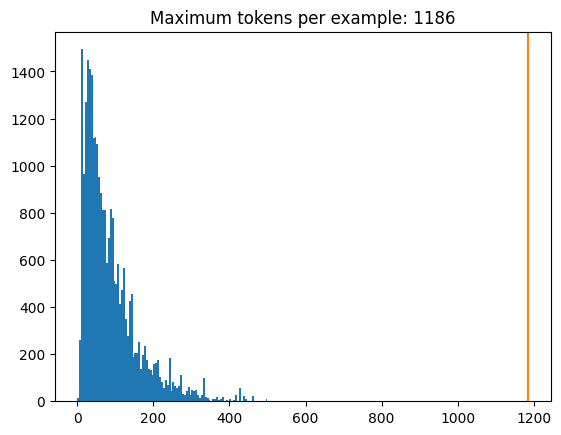

In [39]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}') # 160 will be sufficient

##### preparing dataset

In [40]:
MAX_TOKENS = 160

def preprocess(X, labels, weights):
    project,bid,feat = X

    proj_tokens = tokenizer.tokenize(project).merge_dims(-2,-1)
    bid_tokens = tokenizer.tokenize(bid).merge_dims(-2,-1)

    proj_tokens = proj_tokens[:, :MAX_TOKENS].to_tensor()
    bid_tokens = bid_tokens[:, :MAX_TOKENS].to_tensor()

    return (proj_tokens,bid_tokens,feat),labels,weights

In [41]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 64

def make_ds(ds):
    return (ds
            .shuffle(BUFFER_SIZE, seed=SEED)
            .batch(BATCH_SIZE)
            .map(preprocess,AUTOTUNE)
            .prefetch(AUTOTUNE))

In [42]:
ds_size = len(X_1)

train_size,val_size = int(ds_size*.7),int(ds_size*.1)

train_ds = make_ds( ds.take(train_size) )
val_ds = make_ds( ds.skip(train_size).take(val_size) )
test_ds = make_ds( ds.skip(train_size+val_size) )

In [48]:
target_embed_dim = 4
num_layers = 4
d_model = 128
dff = 256
num_heads = 8
dropout_rate=.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=vocab_size,
    target_embed_dim=target_embed_dim,
    embed_weights_path='models/embeddings.tsv',
    dropout_rate=dropout_rate)

In [45]:
for batch,labels,weights in train_ds.take(1):break

output = transformer(batch[:2])
print(output.shape)

transformer.summary()

(64, 4)
Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3399680   
                                                                 
 decoder (Decoder)           multiple                  5510656   
                                                                 
 dense_19 (Dense)            multiple                  516       
                                                                 
Total params: 8910852 (33.99 MB)
Trainable params: 6862852 (26.18 MB)
Non-trainable params: 2048000 (7.81 MB)
_________________________________________________________________


In [49]:
epochs=20
learning_rate = CustomSchedule(d_model) # used in paper

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)

model = BidsClassifier(transformer, X_3.shape[1])
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()],
    weighted_metrics=[])

model.fit(train_ds,epochs=epochs,validation_data=val_ds)
model.evaluate(test_ds)

Epoch 1/20
157/157 [==============================] - 113s 515ms/step - loss: 1.5446 - accuracy: 0.4518 - recall_4: 0.5407 - precision_4: 0.0600 - val_loss: 1.5977 - val_accuracy: 0.5931 - val_recall_4: 0.3729 - val_precision_4: 0.0799
Epoch 2/20
157/157 [==============================] - 80s 509ms/step - loss: 1.4437 - accuracy: 0.5306 - recall_4: 0.5309 - precision_4: 0.0689 - val_loss: 1.6360 - val_accuracy: 0.8368 - val_recall_4: 0.1780 - val_precision_4: 0.1338
Epoch 3/20
157/157 [==============================] - 81s 515ms/step - loss: 1.3220 - accuracy: 0.5839 - recall_4: 0.5749 - precision_4: 0.0830 - val_loss: 1.3963 - val_accuracy: 0.5917 - val_recall_4: 0.6186 - val_precision_4: 0.1195
Epoch 4/20
157/157 [==============================] - 81s 514ms/step - loss: 1.2524 - accuracy: 0.5917 - recall_4: 0.6319 - precision_4: 0.0914 - val_loss: 1.3611 - val_accuracy: 0.6457 - val_recall_4: 0.6864 - val_precision_4: 0.1473
Epoch 5/20
157/157 [==============================] - 81s 5

[1.4361227750778198,
 0.6869534850120544,
 0.6265560388565063,
 0.1579497903585434]